In [270]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
#from api_import import *
import api_import 

In [271]:
#data = np.genfromtxt("2013_gaz_tracts_36.txt",delimiter=",",)
data = pd.read_csv("../data/gazetter_tracts/2013_gaz_tracts_36.txt",header=0,dtype={'GEOID': np.int64, 
        'ALAND': float, 'AWATER': float, 'ALAND_SQMI': float, 'AWATER_SQMI': float, 
        'INTPTLAT': float, 'INTPTLONG': float})

In [272]:
data.head(5)

,USPS,GEOID,ALAND,AWATER,ALAND_SQMI,AWATER_SQMI,INTPTLAT,INTPTLONG
0,NY,36001000100,2367456,245021,0.914,0.095,42.663754,-73.736909
1,NY,36001000200,2065161,0,0.797,0.000,42.664413,-73.751504
2,NY,36001000300,5779329,55326,2.231,0.021,42.680614,-73.783004
3,NY,36001000401,9017989,134152,3.482,0.052,42.702508,-73.866753
4,NY,36001000403,3138700,0,1.212,0.000,42.676874,-73.805264


In [273]:
#add state, county, county, tract id, block id information to data frame
data['STATE'] = ''
data['STATE_ID'] = ''
data['GEOID'] = data['GEOID'].astype("str")
data['BOROUGH'] = ''
data['COUNTY_ID'] = ''
data['TRACT_ID'] = ''
data['LATMIN'] = 0.0
data['LATMAX'] = 0.0
data['LONGMIN'] = 0.0
data['LONGMAX'] = 0.0
data['ZIPCODE'] = ''
data['FRAC_LAND'] = data['ALAND'] / (data['ALAND'] + data['AWATER'])

## ---IGNORING ZIP CODES SINCE THEY ARE MAIL ROUTES AND NOT ALWAYS MAPPED CORRECTLY TO TRACT + COUNTY CODE COMBINATIONS

In [274]:
#ziplist = zip_tract_dict.keys() #if y[0] == '61']
data.head(5)

,USPS,GEOID,ALAND,AWATER,ALAND_SQMI,AWATER_SQMI,INTPTLAT,INTPTLONG,STATE,STATE_ID,BOROUGH,COUNTY_ID,TRACT_ID,LATMIN,LATMAX,LONGMIN,LONGMAX,ZIPCODE,FRAC_LAND
0,NY,36001000100,2367456,245021,0.914,0.095,42.663754,-73.736909,,,,,,0,0,0,0,,0.906211
1,NY,36001000200,2065161,0,0.797,0.000,42.664413,-73.751504,,,,,,0,0,0,0,,1.000000
2,NY,36001000300,5779329,55326,2.231,0.021,42.680614,-73.783004,,,,,,0,0,0,0,,0.990518
3,NY,36001000401,9017989,134152,3.482,0.052,42.702508,-73.866753,,,,,,0,0,0,0,,0.985342
4,NY,36001000403,3138700,0,1.212,0.000,42.676874,-73.805264,,,,,,0,0,0,0,,1.000000


In [275]:
#function to parse GEOID
def parse_geoid(geoidstr):
    return geoidstr[:2],geoidstr[2:5],geoidstr[5:]

In [276]:
#http://msi.nga.mil/MSISiteContent/StaticFiles/Calculators/degree.html to get meters->lat, long
#latitude (NYC) = 40.7 degrees
#1 degree of latitude = 111048 meters
#1 degree of longitude = 84515 meters 
for irow, row in data.iterrows():
    state, county, tract =  parse_geoid(row['GEOID'])
    data.ix[irow,'STATE_ID'] = state
    data.ix[irow,'COUNTY_ID'] = county
    data.ix[irow,'TRACT_ID'] = tract
    #data.ix[irow,'BLOCK_ID'] = block
    length = np.sqrt(row['ALAND'] + row['AWATER'])  #in meters
    dlat = 0.5 * length * (1./111048.)
    dlon = 0.5 * length * (1./84515.)
    data.ix[irow,'LATMIN'], data.ix[irow,'LATMAX'] = row['INTPTLAT'] - dlat, row['INTPTLAT'] + dlat
    data.ix[irow,'LONGMIN'], data.ix[irow,'LONGMAX'] = row['INTPTLONG'] - dlon, row['INTPTLONG'] + dlon

In [277]:
data.loc[data.COUNTY_ID == "061","BOROUGH"] = "Manhattan"
data.loc[data.COUNTY_ID == "047","BOROUGH"] = "Brooklyn"
data.loc[data.COUNTY_ID == "081","BOROUGH"] = "Queens"
data.loc[data.COUNTY_ID == "085","BOROUGH"] = "Staten"
data.loc[data.COUNTY_ID == "005","BOROUGH"] = "Bronx"
data.BOROUGH.unique()

array(['', 'Bronx', 'Brooklyn', 'Manhattan', 'Queens', 'Staten'], dtype=object)

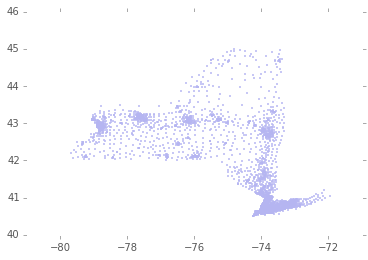

In [280]:
#plot of new york from census tracts
plt.scatter(data['INTPTLONG'],data['INTPTLAT'],s=2)

In [433]:
#Create subsets for nyc 5 boroughs and for manhattan only
nyc = data[(data['COUNTY_ID'] == "061") | (data['COUNTY_ID'] == "047") | 
           (data['COUNTY_ID'] == "005") | (data['COUNTY_ID'] == "081") | 
           (data['COUNTY_ID'] == "085")].reset_index(drop=True)

In [434]:
#zip_tract_dict = zip_to_tract()
tract_zip_dict = api_import.tract_to_zip()
for irow, row in nyc.iterrows():
    if (row['COUNTY_ID'],row['TRACT_ID']) in tract_zip_dict.keys():
        nyc.ix[irow,'ZIPCODE'] = tract_zip_dict[(row['COUNTY_ID'],row['TRACT_ID'])]
    else:
        nyc.ix[irow,'ZIPCODE'] = "00000"

In [435]:
nyc.set_index(['COUNTY_ID', 'TRACT_ID'],inplace=True,drop=True)

In [437]:
nyc.head(5)

USPS        GEOID    ALAND   AWATER  ALAND_SQMI  \
COUNTY_ID TRACT_ID                                                   
005       000100     NY  36005000100  1672467  1032658       0.646   
          000200     NY  36005000200   455322   926899       0.176   
          000400     NY  36005000400   912391   602945       0.352   
          001600     NY  36005001600   485079        0       0.187   
          001900     NY  36005001900  1656134  1139660       0.639   

                    AWATER_SQMI   INTPTLAT  INTPTLONG STATE STATE_ID BOROUGH  \
COUNTY_ID TRACT_ID                                                             
005       000100          0.399  40.793492 -73.883532             36   Bronx   
          000200          0.358  40.803486 -73.860438             36   Bronx   
          000400          0.233  40.808915 -73.850488             36   Bronx   
          001600          0.000  40.818848 -73.858076             36   Bronx   
          001900          0.440  40.800999 -73.909373             36   Bronx   

                       LATMIN     LATMAX    LONGMIN    LONGMAX ZIPCODE  \
COUNTY_ID TRACT_ID                                                       
005       000100    40.786087  40.800898 -73.893262 -73.873801   11370   
          000200    40.798192  40.808779 -73.867393 -73.853482   10473   
          000400    40.803373  40.814458 -73.857771 -73.843206   10473   
          001600    40.815712  40.821984 -73.862197 -73.853956   10473   
          001900    40.793470  40.808528 -73.919265 -73.899481   10455   

                    FRAC_LAND  
COUNTY_ID TRACT_ID             
005       000100     0.618259  
          000200     0.329413  
          000400     0.602105  
          001600     1.000000  
          001900     0.592366

In [448]:
#manhattan = nyc.iloc(nyc['COUNTY_ID'] == "061",:]
manhattan = nyc.ix["061"]

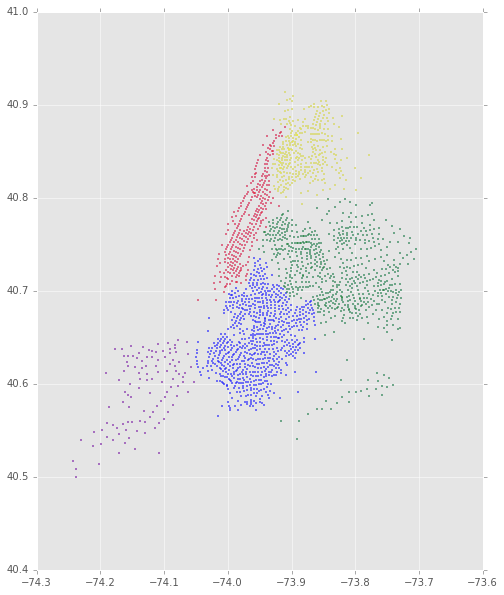

In [450]:
#Plot of NYC color-coded by borough! 
import matplotlib as mpl
mpl.rcParams["figure.figsize"] = (8,10)
plt.scatter(nyc['INTPTLONG'],nyc['INTPTLAT'],s=2)
plt.scatter(nyc.ix["061"]['INTPTLONG'],nyc.ix["061"]['INTPTLAT'],s=2,color='red',alpha=0.5)
plt.scatter(nyc.ix["047"]['INTPTLONG'],nyc.ix["047"]['INTPTLAT'],s=2,color='blue',alpha=0.5)
plt.scatter(nyc.ix["081"]['INTPTLONG'],nyc.ix["081"]['INTPTLAT'],s=2,color='green',alpha=0.5)
plt.scatter(nyc.ix["085"]['INTPTLONG'],nyc.ix["085"]['INTPTLAT'],s=2,color='purple',alpha=0.5)
plt.scatter(nyc.ix["005"]['INTPTLONG'],nyc.ix["005"]['INTPTLAT'],s=2,color='yellow',alpha=0.5)

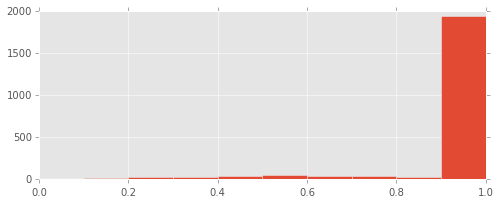

In [451]:
#Fraction of NYC census tracts that are 100% over land = 90%
mpl.rcParams["figure.figsize"] = (8,3)
nyc['FRAC_LAND'].hist(bins=10)

In [452]:
print "fraction of tract census areas 90% land = ",float(len(nyc[nyc['FRAC_LAND'] > 0.90]))/len(nyc['FRAC_LAND'])

fraction of tract census areas 90% land =  0.897092754961


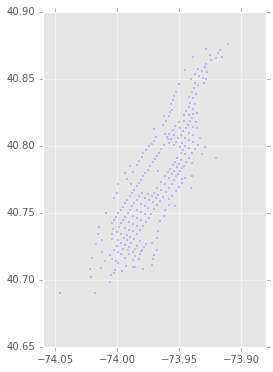

In [453]:
mpl.rcParams["figure.figsize"] = (4,6)
plt.scatter(manhattan['INTPTLONG'],manhattan['INTPTLAT'],s=3)

In [454]:
#print manhattan[:,['LONGMIN','LONGMAX','LATMIN','LATMAX']]
print manhattan.index

Index([u'000100', u'000201', u'000202', u'000500', u'000600', u'000700', u'000800', u'000900', u'001001', u'001002', u'001200', u'001300', u'001401', u'001402', u'001501', u'001502', u'001600', u'001800', u'002000', u'002100', u'002201', u'002202', u'002400', u'002500', u'002601', u'002602', u'002700', u'002800', u'002900', u'003001', u'003002', u'003100', u'003200', u'003300', u'003400', u'003601', u'003602', u'003700', u'003800', u'003900', u'004000', u'004100', u'004200', u'004300', u'004400', u'004500', u'004700', u'004800', u'004900', u'005000', u'005200', u'005400', u'005501', u'005502', u'005600', u'005700', u'005800', u'005900', u'006000', u'006100', u'006200', u'006300', u'006400', u'006500', u'006600', u'006700', u'006800', u'006900', u'007000', u'007100', u'007200', u'007300', u'007400', u'007500', u'007600', u'007700', u'007800', u'007900', u'008000', u'008100', u'008200', u'008300', u'008400', u'008601', u'008602', u'008603', u'008700', u'008800', u'008900', u'009000', u'0

In [134]:
#--------------------------

###Combine Geographical Data with Population, Economic, Demographic Data

In [455]:
#specify features in census database

census_vars = [["cty", {"description": "County", "name": "COUNTY_ID"}],
               ["tr", {"description": "Tract", "name": "TRACT_ID"}],
["DP03_0051E", {"description": "Total households", "name": "hh_total"}],
["DP03_0052E" , {"description": "Total households < 10,000","name": "hh1"}],
["DP03_0053E" , {"description": "Total households 10,000 to 14,999","name": "hh2"}],
["DP03_0054E" , {"description": "Total households 15,000 to 24,999","name": "hh3"}],
["DP03_0055E" , {"description": "Total households 25,000 to 34,999","name": "hh4"}],
["DP03_0056E" , {"description": "Total households 35,000 to 49,999","name": "hh5"}],
["DP03_0057E" , {"description": "Total households 50,000 to 74,999","name": "hh6"}],
["DP03_0058E" , {"description": "Total households 75,000 to 99,999","name": "hh7"}],
["DP03_0059E" , {"description": "Total households 100,000 to 149,999","name": "hh8"}],
["DP03_0060E" , {"description": "Total households 150,000 to 199,999","name": "hh9"}],
["DP03_0061E" , {"description": "Total households 200,000 + ","name": "hh10"}],
["DP03_0062E" , {"description": "Total households MEDIAN","name": "hhmedian"}], #dollars
["DP03_0063E" , {"description": "Total households MEAN","name": "hhmean"}],   #dollars
["DP05_0001E" , {"description": "Total population","name": "pop_total"}],
["DP05_0008E" , {"description": "Total population 20 to 24 years old","name": "pop1"}],
["DP05_0009E" , {"description": "Total population 25 to 34 years old","name": "pop2"}],
["DP05_0010E" , {"description": "Total population 35 to 44 years old","name": "pop3"}],
["DP05_0011E" , {"description": "Total population 45 to 54 years old","name": "pop4"}],
["DP05_0012E" , {"description": "Total population 55 to 59 years old","name": "pop5"}],
["DP05_0013E" , {"description": "Total population 60 to 64 years old","name": "pop6"}],
["DP05_0014E" , {"description": "Total population 65 to 74 years old","name": "pop7"}],
["DP05_0015E" , {"description": "Total population 75 to 84 years old","name": "pop8"}],
["DP05_0016E" , {"description": "Total population 85+","name": "pop9"}],
["DP05_0039E" , {"description": "Race: Asian","name": "pop_asian"}],
["DP05_0033E" , {"description": "Race: African American","name": "pop_black"}],
["DP05_0032E" , {"description": "Race: White","name": "pop_white"}],
["DP05_0034E" , {"description": "Race: Native American","name": "pop_native"}],
["DP05_0047E" , {"description": "Race: Native Hawaiian and Other Pacific Islander","name": "pop_pacific"}],
["DP05_0066E" , {"description": "Hispanic and Latino of any race","name": "pop_latino"}]]

census_vars_keys = [x[0] for x in census_vars]
census_vars_names = [x[1]["name"] for x in census_vars]

print census_vars_keys
print census_vars_names

['cty', 'tr', 'DP03_0051E', 'DP03_0052E', 'DP03_0053E', 'DP03_0054E', 'DP03_0055E', 'DP03_0056E', 'DP03_0057E', 'DP03_0058E', 'DP03_0059E', 'DP03_0060E', 'DP03_0061E', 'DP03_0062E', 'DP03_0063E', 'DP05_0001E', 'DP05_0008E', 'DP05_0009E', 'DP05_0010E', 'DP05_0011E', 'DP05_0012E', 'DP05_0013E', 'DP05_0014E', 'DP05_0015E', 'DP05_0016E', 'DP05_0039E', 'DP05_0033E', 'DP05_0032E', 'DP05_0034E', 'DP05_0047E', 'DP05_0066E']
['COUNTY_ID', 'TRACT_ID', 'hh_total', 'hh1', 'hh2', 'hh3', 'hh4', 'hh5', 'hh6', 'hh7', 'hh8', 'hh9', 'hh10', 'hhmedian', 'hhmean', 'pop_total', 'pop1', 'pop2', 'pop3', 'pop4', 'pop5', 'pop6', 'pop7', 'pop8', 'pop9', 'pop_asian', 'pop_black', 'pop_white', 'pop_native', 'pop_pacific', 'pop_latino']


In [456]:
bronx_df = api_import.query_census(census_vars_keys, "05")
manhattan_df = api_import.query_census(census_vars_keys, "61")
queens_df = api_import.query_census(census_vars_keys, "81")
brooklyn_df = api_import.query_census(census_vars_keys, "47")
staten_df = api_import.query_census(census_vars_keys, "85")

In [457]:
#Concatenate information for all boroughs
dfs = [manhattan_df,bronx_df,queens_df,brooklyn_df,staten_df]
census_df = pd.concat(dfs)
census_df = census_df.reset_index(drop=True)

In [458]:
census_df.rename(columns=dict(zip(census_vars_keys, census_vars_names)), inplace=True)
census_df.loc[census_df['hhmedian'] == "250,000+","hhmedian"] = "250000"
census_df.loc[census_df['hhmean'] == "250,000+","hhmean"] = "250000"
census_df.loc[census_df['hhmedian'] == "-","hhmedian"] = "NaN"
census_df.loc[census_df['hhmean'] == "-","hhmean"] = "NaN"
census_df.loc[census_df['hhmean'] == "N","hhmean"] = "NaN"

In [459]:
census_df.columns

Index([u'COUNTY_ID', u'TRACT_ID', u'hh_total', u'hh1', u'hh2', u'hh3', u'hh4', u'hh5', u'hh6', u'hh7', u'hh8', u'hh9', u'hh10', u'hhmedian', u'hhmean', u'pop_total', u'pop1', u'pop2', u'pop3', u'pop4', u'pop5', u'pop6', u'pop7', u'pop8', u'pop9', u'pop_asian', u'pop_black', u'pop_white', u'pop_native', u'pop_pacific', u'pop_latino', u'state', u'county', u'tract'], dtype='object')

In [460]:
#convert all the "strings" to numeric data PRIOR to merging with geographic data
for col in census_df.columns:
    if col not in ['COUNTY_ID', 'TRACT_ID']:
        census_df[col] = census_df[col].astype(float)

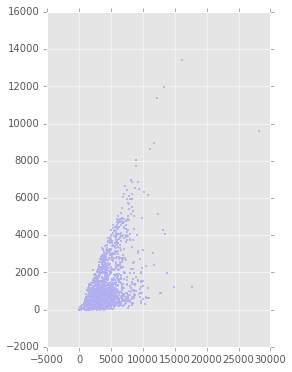

In [461]:
import matplotlib.pyplot as plt
plt.scatter(census_df['pop_total'],census_df['pop_latino'],s=3)

In [462]:
frac_latino = np.array(census_df['pop_latino'] / census_df['pop_total'])
print type(frac_latino)

<type 'numpy.ndarray'>


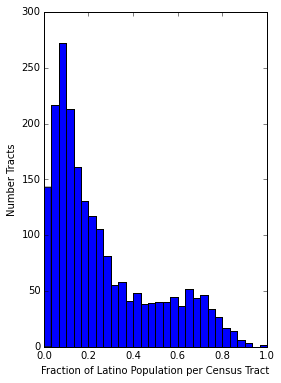

In [214]:
plt.hist(frac_latino[~np.isnan(frac_latino)],bins=30);
plt.xlabel("Fraction of Latino Population per Census Tract")
plt.ylabel("Number Tracts")

In [463]:
census_df.head(5)

,COUNTY_ID,TRACT_ID,hh_total,hh1,hh2,hh3,hh4,hh5,hh6,hh7,...,pop9,pop_asian,pop_black,pop_white,pop_native,pop_pacific,pop_latino,state,county,tract
0,061,000100,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,36,61,100
1,061,000201,940,208,139,235,39,77,142,51,...,34,1328,200,675,29,0,927,36,61,201
2,061,000202,3338,686,384,509,450,386,459,111,...,252,1429,991,3812,0,0,3766,36,61,202
3,061,000500,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,36,61,500
4,061,000600,3912,1061,608,512,389,324,496,152,...,351,6940,877,1262,9,15,3063,36,61,600


In [464]:
census_df.set_index(['COUNTY_ID', 'TRACT_ID'],inplace=True,drop=True)
census_df.head(5)

0                   hh_total   hh1  hh2  hh3  hh4  hh5  hh6  hh7  hh8  hh9  \
COUNTY_ID TRACT_ID                                                           
061       000100           0     0    0    0    0    0    0    0    0    0   
          000201         940   208  139  235   39   77  142   51   39    0   
          000202        3338   686  384  509  450  386  459  111  218   33   
          000500           0     0    0    0    0    0    0    0    0    0   
          000600        3912  1061  608  512  389  324  496  152  250   16   

0                   ...    pop9  pop_asian  pop_black  pop_white  pop_native  \
COUNTY_ID TRACT_ID  ...                                                        
061       000100    ...       0          0          0          0           0   
          000201    ...      34       1328        200        675          29   
          000202    ...     252       1429        991       3812           0   
          000500    ...       0          0          0          0           0   
          000600    ...     351       6940        877       1262           9   

0                   pop_pacific  pop_latino  state  county  tract  
COUNTY_ID TRACT_ID                                                 
061       000100              0           0     36      61    100  
          000201              0         927     36      61    201  
          000202              0        3766     36      61    202  
          000500              0           0     36      61    500  
          000600             15        3063     36      61    600  

[5 rows x 32 columns]

In [465]:
nyc.head(5)

USPS        GEOID    ALAND   AWATER  ALAND_SQMI  \
COUNTY_ID TRACT_ID                                                   
005       000100     NY  36005000100  1672467  1032658       0.646   
          000200     NY  36005000200   455322   926899       0.176   
          000400     NY  36005000400   912391   602945       0.352   
          001600     NY  36005001600   485079        0       0.187   
          001900     NY  36005001900  1656134  1139660       0.639   

                    AWATER_SQMI   INTPTLAT  INTPTLONG STATE STATE_ID BOROUGH  \
COUNTY_ID TRACT_ID                                                             
005       000100          0.399  40.793492 -73.883532             36   Bronx   
          000200          0.358  40.803486 -73.860438             36   Bronx   
          000400          0.233  40.808915 -73.850488             36   Bronx   
          001600          0.000  40.818848 -73.858076             36   Bronx   
          001900          0.440  40.800999 -73.909373             36   Bronx   

                       LATMIN     LATMAX    LONGMIN    LONGMAX ZIPCODE  \
COUNTY_ID TRACT_ID                                                       
005       000100    40.786087  40.800898 -73.893262 -73.873801   11370   
          000200    40.798192  40.808779 -73.867393 -73.853482   10473   
          000400    40.803373  40.814458 -73.857771 -73.843206   10473   
          001600    40.815712  40.821984 -73.862197 -73.853956   10473   
          001900    40.793470  40.808528 -73.919265 -73.899481   10455   

                    FRAC_LAND  
COUNTY_ID TRACT_ID             
005       000100     0.618259  
          000200     0.329413  
          000400     0.602105  
          001600     1.000000  
          001900     0.592366

In [466]:
nyc.columns

Index([u'USPS', u'GEOID', u'ALAND', u'AWATER', u'ALAND_SQMI', u'AWATER_SQMI', u'INTPTLAT', u'INTPTLONG', u'STATE', u'STATE_ID', u'BOROUGH', u'LATMIN', u'LATMAX', u'LONGMIN', u'LONGMAX', u'ZIPCODE', u'FRAC_LAND'], dtype='object')

In [467]:
#Drop columns with same names as in geo DF - mysql does not accept duplicate column names
census_df.columns
census_df.drop('state', axis=1, inplace=True)
census_df.drop('county', axis=1, inplace=True)
census_df.drop('tract', axis=1, inplace=True)

In [399]:
census_df.columns

Index([u'hh_total', u'hh1', u'hh2', u'hh3', u'hh4', u'hh5', u'hh6', u'hh7', u'hh8', u'hh9', u'hh10', u'hhmedian', u'hhmean', u'pop_total', u'pop1', u'pop2', u'pop3', u'pop4', u'pop5', u'pop6', u'pop7', u'pop8', u'pop9', u'pop_asian', u'pop_black', u'pop_white', u'pop_native', u'pop_pacific', u'pop_latino'], dtype='object')

In [468]:
df = nyc.join(census_df, how='inner',lsuffix="",rsuffix="")

In [469]:
len(nyc),len(census_df),len(df)

(2167, 2167, 2167)

In [470]:
import matplotlib
matplotlib.style.use('ggplot')

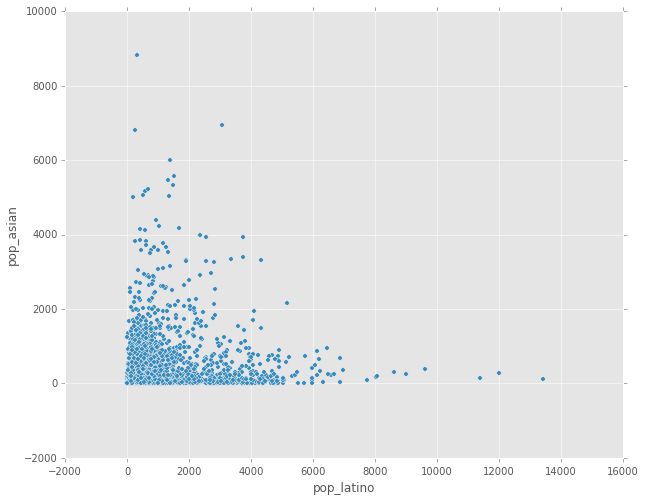

In [471]:
mpl.rcParams["figure.figsize"] = (10,8)
df.plot(kind='scatter', x='pop_latino', y='pop_asian')

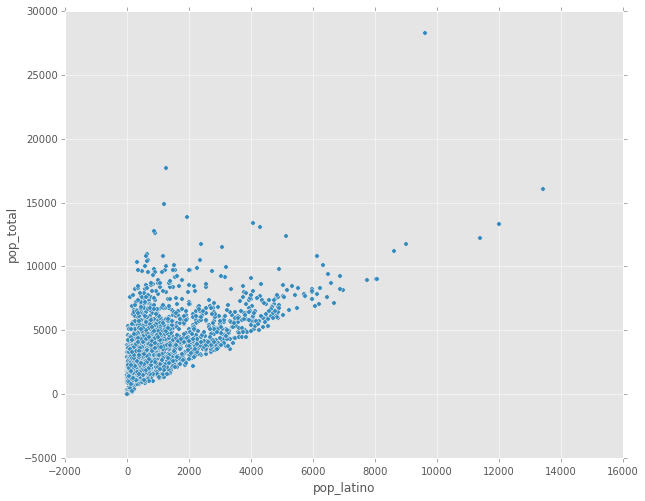

In [472]:
df.plot(kind='scatter', x='pop_latino', y='pop_total')

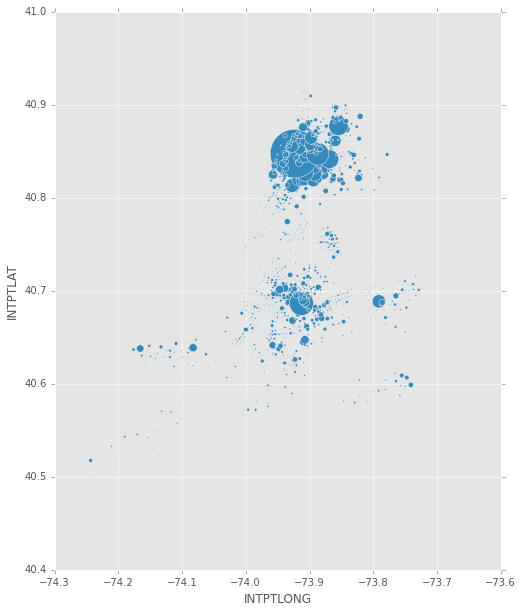

In [473]:
mpl.rcParams["figure.figsize"] = (8,10)
dfsub = df[df['pop_total'] > 0.0]  #dfsub used for plotting where pop_total > 0.0
dfsub.plot(kind='scatter', x='INTPTLONG', y='INTPTLAT',s=0.5*dfsub['pop_latino']/dfsub['pop_asian'])

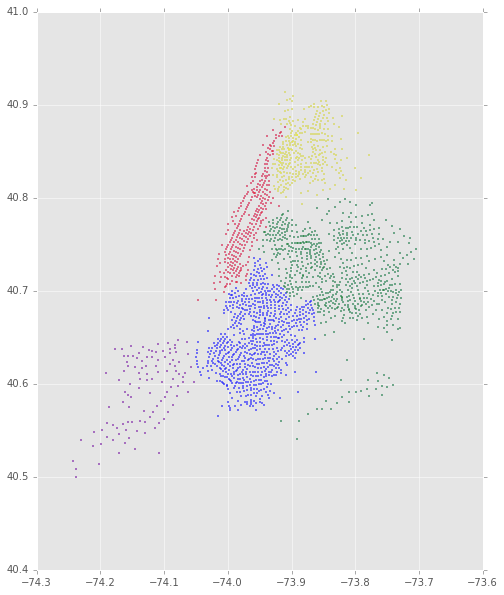

In [475]:
plt.scatter(nyc['INTPTLONG'],nyc['INTPTLAT'],s=2)
plt.scatter(nyc.ix["061"]['INTPTLONG'],nyc.ix["061"]['INTPTLAT'],s=2,color='red',alpha=0.5)
plt.scatter(nyc.ix["047"]['INTPTLONG'],nyc.ix["047"]['INTPTLAT'],s=2,color='blue',alpha=0.5)
plt.scatter(nyc.ix["081"]['INTPTLONG'],nyc.ix["081"]['INTPTLAT'],s=2,color='green',alpha=0.5)
plt.scatter(nyc.ix["085"]['INTPTLONG'],nyc.ix["085"]['INTPTLAT'],s=2,color='purple',alpha=0.5)
plt.scatter(nyc.ix["005"]['INTPTLONG'],nyc.ix["005"]['INTPTLAT'],s=2,color='yellow',alpha=0.5)

###Mean vs Median Income! 

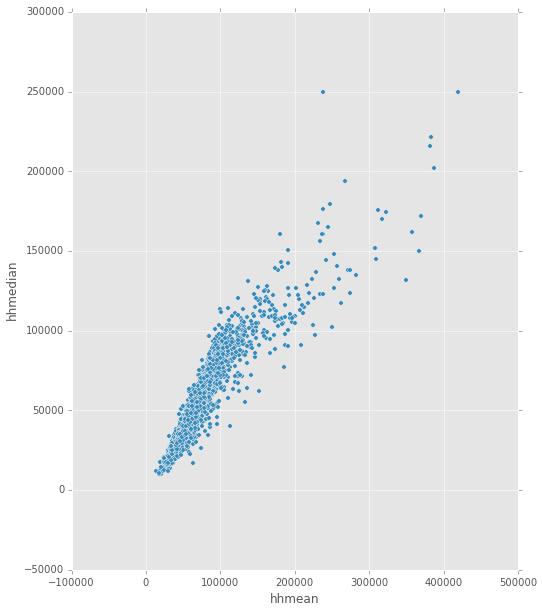

In [476]:
df.plot(kind='scatter', x='hhmean', y='hhmedian')

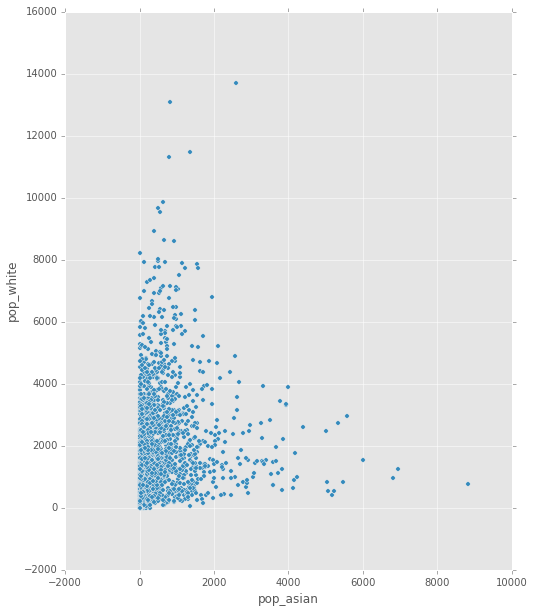

In [478]:
df.plot(kind='scatter', x='pop_asian', y='pop_white')

#SAVE CENSUS DATA to MYSQL! 

In [479]:
#df.to_json("../data/census_data.json")
#df.to_json()
df.head()

USPS        GEOID    ALAND   AWATER  ALAND_SQMI  \
COUNTY_ID TRACT_ID                                                   
005       000100     NY  36005000100  1672467  1032658       0.646   
          000200     NY  36005000200   455322   926899       0.176   
          000400     NY  36005000400   912391   602945       0.352   
          001600     NY  36005001600   485079        0       0.187   
          001900     NY  36005001900  1656134  1139660       0.639   

                    AWATER_SQMI   INTPTLAT  INTPTLONG STATE STATE_ID  \
COUNTY_ID TRACT_ID                                                     
005       000100          0.399  40.793492 -73.883532             36   
          000200          0.358  40.803486 -73.860438             36   
          000400          0.233  40.808915 -73.850488             36   
          001600          0.000  40.818848 -73.858076             36   
          001900          0.440  40.800999 -73.909373             36   

                       ...     pop6  pop7  pop8  pop9  pop_asian pop_black  \
COUNTY_ID TRACT_ID     ...                                                   
005       000100       ...      110    35     7     0        202      5388   
          000200       ...      219   337   214    94        259      1504   
          000400       ...      268   191   171    75        116      1568   
          001600       ...      350   486   284   123          0      1717   
          001900       ...       53   131    15     8         34       654   

                    pop_white  pop_native  pop_pacific  pop_latino  
COUNTY_ID TRACT_ID                                                  
005       000100         1361           0            0        3159  
          000200         1352          35            0        3236  
          000400         1339           0            0        3495  
          001600         1535           0            0        3692  
          001900          995           0            0        1567  

[5 rows x 46 columns]

In [480]:
from pandas.io import sql
import pymysql as mdb

#con = mdb.connect('localhost', 'root', '', 'census_db',
#        unix_socket="/opt/local/var/run/mysql56/mysqld.sock") #host, user, password, #database

In [492]:
#sql.write_frame(df, con=con, name='table_census', 
#               if_exists='replace', flavor='mysql')

#df.reset_index().to_sql("table_census", con = con, flavor='mysql', schema=None, if_exists='replace')

#Test SQL table

###remember for sql access, < mysql -u root -p > 

In [494]:
#con = mdb.connect('localhost', 'root', '', 'census_db',
#        unix_socket="/opt/local/var/run/mysql56/mysqld.sock") #host, user, password, #database

#with con: 
#    cur = con.cursor()
#    cur.execute("SELECT hhmean,hhmedian,pop_total FROM table_census")
#    rows = cur.fetchall()
#    for row in rows:
#        print row

In [493]:
#Now read in to pandas from sql
#df2 = pd.read_sql("table_census", con, coerce_float=True)

In [503]:
df.reset_index().to_json("../data/census_data.json",orient="records")

In [506]:
df2 = pd.read_json("../data/census_data.json")
df2.head(5)

,ALAND,ALAND_SQMI,AWATER,AWATER_SQMI,BOROUGH,COUNTY_ID,FRAC_LAND,GEOID,INTPTLAT,INTPTLONG,...,pop7,pop8,pop9,pop_asian,pop_black,pop_latino,pop_native,pop_pacific,pop_total,pop_white
0,1672467,0.646,1032658,0.399,Bronx,5,0.618259,36005000100,40.793492,-73.883532,...,35,7,0,202,5388,3159,0,0,9191,1361
1,455322,0.176,926899,0.358,Bronx,5,0.329413,36005000200,40.803486,-73.860438,...,337,214,94,259,1504,3236,35,0,4858,1352
2,912391,0.352,602945,0.233,Bronx,5,0.602105,36005000400,40.808915,-73.850488,...,191,171,75,116,1568,3495,0,0,5344,1339
3,485079,0.187,0,0.000,Bronx,5,1.000000,36005001600,40.818848,-73.858076,...,486,284,123,0,1717,3692,0,0,5215,1535
4,1656134,0.639,1139660,0.440,Bronx,5,0.592366,36005001900,40.800999,-73.909373,...,131,15,8,34,654,1567,0,0,2562,995


In [507]:
df2.set_index(['COUNTY_ID', 'TRACT_ID'],inplace=True,drop=True)

In [510]:
df2.ix[47]

,ALAND,ALAND_SQMI,AWATER,AWATER_SQMI,BOROUGH,FRAC_LAND,GEOID,INTPTLAT,INTPTLONG,LATMAX,...,pop7,pop8,pop9,pop_asian,pop_black,pop_latino,pop_native,pop_pacific,pop_total,pop_white
TRACT_ID,,,,,,,,,,,,,,,,,,,,,
100,224486,0.087,0,0.000,Brooklyn,1.000000,36047000100,40.700283,-73.994016,40.702417,...,485,285,105,314,309,522,49,0,4610,3532
200,276927,0.107,0,0.000,Brooklyn,1.000000,36047000200,40.653247,-74.011068,40.655617,...,68,4,4,0,161,1385,0,0,1612,503
301,214944,0.083,0,0.000,Brooklyn,1.000000,36047000301,40.696416,-73.997495,40.698504,...,295,208,265,188,237,356,18,0,4214,3385
501,83724,0.032,0,0.000,Brooklyn,1.000000,36047000501,40.695814,-73.994701,40.697117,...,213,137,70,398,299,223,0,0,4400,3467
502,96812,0.037,0,0.000,Brooklyn,1.000000,36047000502,40.695135,-73.992861,40.696535,...,211,96,55,180,67,177,0,0,2543,2084
700,174194,0.067,0,0.000,Brooklyn,1.000000,36047000700,40.692320,-73.997299,40.694199,...,241,157,29,156,50,275,0,0,3827,3440
900,161378,0.062,0,0.000,Brooklyn,1.000000,36047000900,40.691736,-73.991627,40.693544,...,151,53,32,412,227,313,0,0,4351,3312
1100,168508,0.065,0,0.000,Brooklyn,1.000000,36047001100,40.693290,-73.987709,40.695139,...,4,0,0,84,77,50,20,0,580,340
1300,291217,0.112,0,0.000,Brooklyn,1.000000,36047001300,40.697625,-73.988383,40.700055,...,203,63,21,314,302,386,0,0,2561,1647


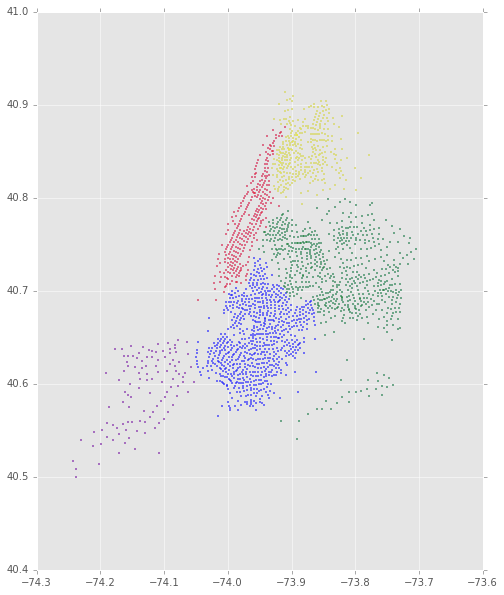

In [514]:
import matplotlib.pyplot as plt
plt.scatter(df2['INTPTLONG'],nyc['INTPTLAT'],s=2)
plt.scatter(df2.ix[61]['INTPTLONG'],df2.ix[61]['INTPTLAT'],s=2,color='red',alpha=0.5)
plt.scatter(df2.ix[47]['INTPTLONG'],df2.ix[47]['INTPTLAT'],s=2,color='blue',alpha=0.5)
plt.scatter(df2.ix[81]['INTPTLONG'],df2.ix[81]['INTPTLAT'],s=2,color='green',alpha=0.5)
plt.scatter(df2.ix[85]['INTPTLONG'],df2.ix[85]['INTPTLAT'],s=2,color='purple',alpha=0.5)
plt.scatter(df2.ix[5]['INTPTLONG'],df2.ix[5]['INTPTLAT'],s=2,color='yellow',alpha=0.5)